In [1]:
##運動実行のデータからCSPフィルタを形成,運動想起の特徴を抽出してみる
#import library
import os
import numpy as np
import scipy.io
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne.decoding import CSP
import mne
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#filePath = '/Users/yamamotokouhei/subjectsData/data20221122'
#filePath = '/Users/yamamotokouhei/subjectsData/braindata20221003'
#filePath = '/Users/yamamotokouhei/subjectsData/data20230111'
#filePath = '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/20230214_zikken'
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/20230208_zzikken'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data65_label2 = list()#label2のデータ
o_data65_label3 = list()#label3のデータ
o_data65_label4 = list()#label4のデータ
o_data = list()
label_data = list()#labelを結合したデータ
task1_data = list()
task2_data = list()

All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    # b = np.average(after_data)
    # c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['EEG_grasping_08-Feb-2023_sub1-1.mat', 'EEG_grasping_08-Feb-2023_sub1-2.mat', 'EEG_grasping_08-Feb-2023_sub1-3.mat', 'EEG_grasping_08-Feb-2023_sub2-1.mat', 'EEG_grasping_08-Feb-2023_sub2-2.mat', 'EEG_grasping_08-Feb-2023_sub2-3.mat', 'EEG_grasping_08-Feb-2023_sub3-1.mat', 'EEG_grasping_08-Feb-2023_sub3-2.mat', 'EEG_grasping_08-Feb-2023_sub3-3.mat', 'EEG_grasping_08-Feb-2023_sub4-2.mat', 'EEG_grasping_08-Feb-2023_sub4-3.mat', 'EEG_grasping_08-Feb-2023_sub5-1.mat', 'EEG_grasping_08-Feb-2023_sub5-2.mat', 'EEG_grasping_08-Feb-2023_sub5-3.mat', 'EEG_grasping_08-Feb-2023_sub4-1.mat']


In [2]:
#運動想起の読み込み
#label1の設定
file_name1 = [file_name[14],file_name[9],file_name[10]]
file_num1 = len(file_name1)
#label2の設定
file_name2 = [file_name[11],file_name[12],file_name[13]]
file_num2 = len(file_name2)
# 変数など
trial_num = 30
all_trial = len(file_name1)+len(file_name2) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
#label2を読み込む
for s in range(file_num2):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name2[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label2.append(o_data)
print("image data_loading")

image data_loading


In [3]:
c1 = o_data65_label1[0].eeg[: , 1024*2:8190]
c2 = o_data65_label2[0].eeg[: , 1024*2:8190]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , 1024*2:8190]
    g2 = o_data65_label2[n+1].eeg[: , 1024*2:8190]
    c1 = np.dstack([c1, g1])
    c2 = np.dstack([c2, g2])


In [4]:
all_data = np.dstack([c1, c2])
all_data = all_data.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(180, 64, 6142)


In [5]:
#ラベル生成
label = np.zeros(180,dtype=int)
label[90:] = 1
# a = list()
# b = list() 
# for n in range(len(file_name1)*trial_num):  # all_trial
#     label1 = o_data65_label1[n].label
#     label2 = o_data65_label2[n].label
#     a.append(label1)
#     b.append(label2)
# label = a+b

In [6]:
label = np.array(label)
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [7]:
# #preprocessing
filter3 = signal.firwin(numtaps=51, cutoff=[1, 30], fs=1024, pass_zero=False)
for i in range(180):
    all_data[i] -=np.mean(all_data[i])
    for j in range(64):
        all_data[i][j] = signal.lfilter(filter3, 1, all_data[i][j][:])

In [8]:
train_data, test_data, train_label, test_label =train_test_split(all_data, label, test_size=0.2,random_state=42)

In [18]:
print(test_label)

[0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0]


In [9]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=4, log=None, reg=None, norm_trace=False,cov_est='epoch')
csp = CSP(n_components=2, log=None, reg=None,cov_est='epoch')
# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, train_data, train_label, cv=3, n_jobs=None)
print(scores)

Computing rank from data with rank=None
    Using tolerance 1.3e+05 (2.2e-16 eps * 64 dim * 9.4e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+05 (2.2e-16 eps * 64 dim * 9e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+05 (2.2e-16 eps * 64 dim * 9.3e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+05 (2.2e-16 eps * 64 dim * 9e+18  max singular value)
    

In [10]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('biosemi64')


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

Classification accuracy: 1.000000 / Chance level: 0.500000
Computing rank from data with rank=None
    Using tolerance 1.5e+05 (2.2e-16 eps * 64 dim * 1.1e+19  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+05 (2.2e-16 eps * 64 dim * 1.1e+19  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+05 (2.2e-16 eps * 64 dim * 9.2e+18  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.

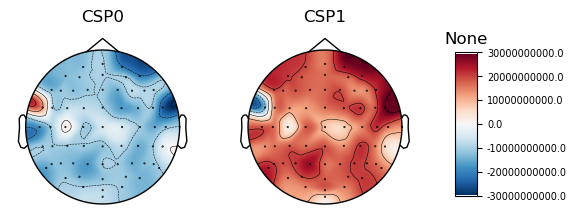

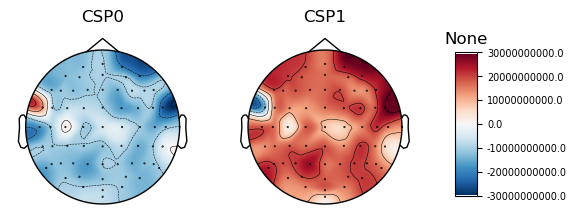

In [11]:
# Printing the results
class_balance = np.mean(train_label == train_label[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
kenshou = csp.fit_transform(train_data, train_label)
csp.fit_transform(train_data, train_label)
csp.plot_patterns(info,ch_type='eeg', units='None', size=1.5)

(144, 2)


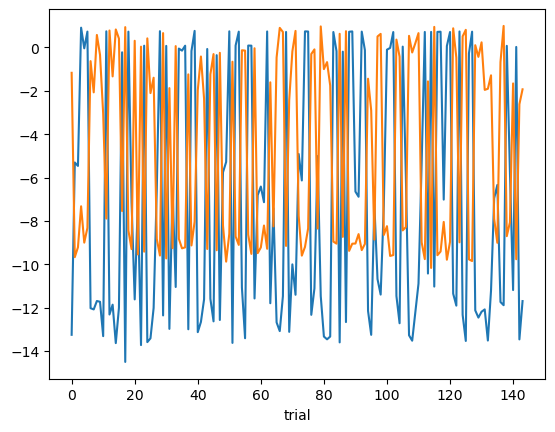

In [12]:
print(np.shape(kenshou))
plt.xlabel('trial')
plt.plot(kenshou)
plt.show()

(36, 2)


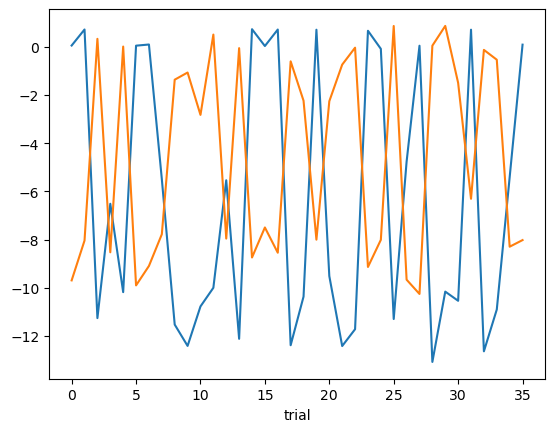

In [13]:
basac = csp.transform(test_data)
print(np.shape(basac))
plt.xlabel('trial')
plt.plot(basac)
plt.show()

(180, 2)


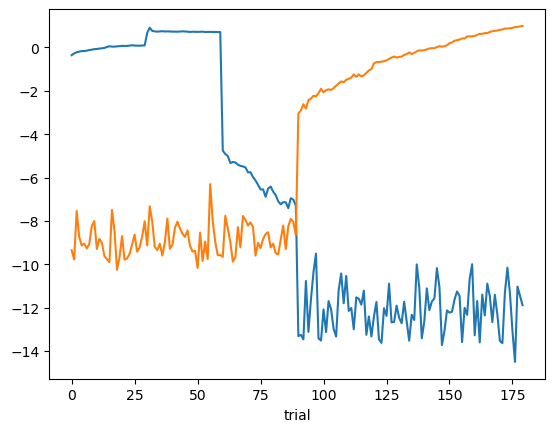

In [14]:
conform_data = csp.transform(all_data)
print(np.shape(conform_data))
plt.xlabel('trial')
plt.plot(conform_data)
plt.show()

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
model =SVC(kernel='linear')
# Stratified k-Fold で汎化性能を評価する
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # 評価する指標
score_funcs = [
        'accuracy',
        'precision',
        'recall',
        'f1',
    ]
    # Cross Validation で検証する
scores = cross_validate(model, kenshou, train_label, cv=skf, scoring=score_funcs)
    # 得られた指標を出力する
print('accuracy:', scores['test_accuracy'].mean())
print('precision:', scores['test_precision'].mean())
print('recall:', scores['test_recall'].mean())
print('f1:', scores['test_f1'].mean())


model.fit(kenshou,train_label)

pred = model.predict(basac)
print(classification_report(pred, test_label))
print(pred)

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

[0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0]


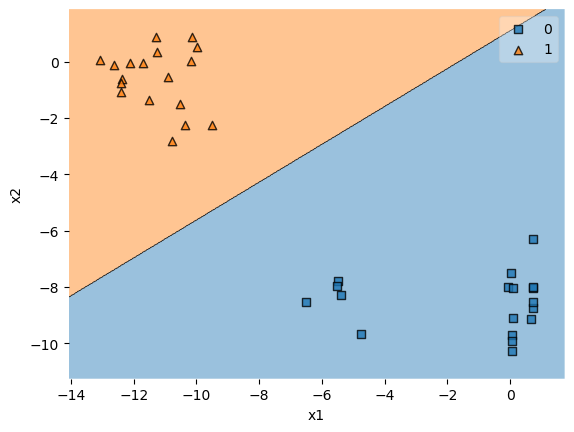

In [16]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(basac, test_label, clf=model)
plt.xlabel('x1')            # x軸ラベル
plt.ylabel('x2')
# plt.xlim(-5, 4)
# plt.ylim(-5, 2)
plt.show()

In [21]:
model.predict(basac[0])


ValueError: Expected 2D array, got 1D array instead:
array=[ 0.05619696 -9.6897445 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.